In [1]:
!pip install h5py lightning scikit-learn matplotlib scipy torchmetrics seaborn

In [2]:
import os
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import lightning as L
from scipy.signal import spectrogram, stft

from tqdm import tqdm
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader

L.seed_everything(42)
torch.set_float32_matmul_precision('medium')

Seed set to 42


# TP3: Reconnaissance de signaux de communication par apprentissage profond 

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>

**Membres:**
- Octave Jeanne
- Alexandre Devaux--Rivière

Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb 

2 séances de TP sur ce sujet : le 5 novembre (1h00), le 12 novembre (3h). 
Le cours du 19 novembre sera partagé en 3 : cours sur la séparation de sources audio / présentation des mini projets et organisation des soutenances / fin de ce TP.<br> 
Deadline pour le rendu du TP: 26 novembre 2025, 13h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur 
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie 
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié. 

L'émetteur peut provenir de 6 catégories différentes. 
Les paramètres différenciant les différentes catégories sont 
- le type de modulation 
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données 
- le débit de la transmission 

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0. 


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation 
électromagnétique comme : 
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données). 
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont: 

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html. 
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via: 
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR 
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation. 


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet. 
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones". 

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données : 
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones 
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage 
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [3]:
TRAIN_PATH = './train.hdf5'
TEST_PATH = './test.hdf5'
VAL_PATH = './validation.hdf5'
SAMPLES_PATH = './samples.hdf5'

In [4]:
data = h5py.File(TRAIN_PATH , 'r')

signals = np.array(data['signaux'])
snr = np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [5]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

In [6]:
data = h5py.File(TRAIN_PATH , 'r')

labels = get_labels(data)
label_to_id= {v: k for k, v in labels.items()}
id_to_label = {k: v for k, v in labels.items()}

data.close()

labels

{1: 'N-PSK8',
 0: 'N-QAM16',
 2: 'N-QPSK',
 4: 'W-PSK8-V1',
 5: 'W-PSK8-V2',
 3: 'W-QAM16'}

### Visualisation des données 

Commencez par étudier les données: 

    - observez leur taille 
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement 
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez 

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering 

In [7]:
print(f'signals.shape\t:\t{signals.shape}')
print(f'snr.shape\t:\t{snr.shape}')
print(f'labels_id.shape\t:\t{labels_id.shape}')

signals.shape	:	(30000, 2048, 2)
snr.shape	:	(30000,)
labels_id.shape	:	(30000,)


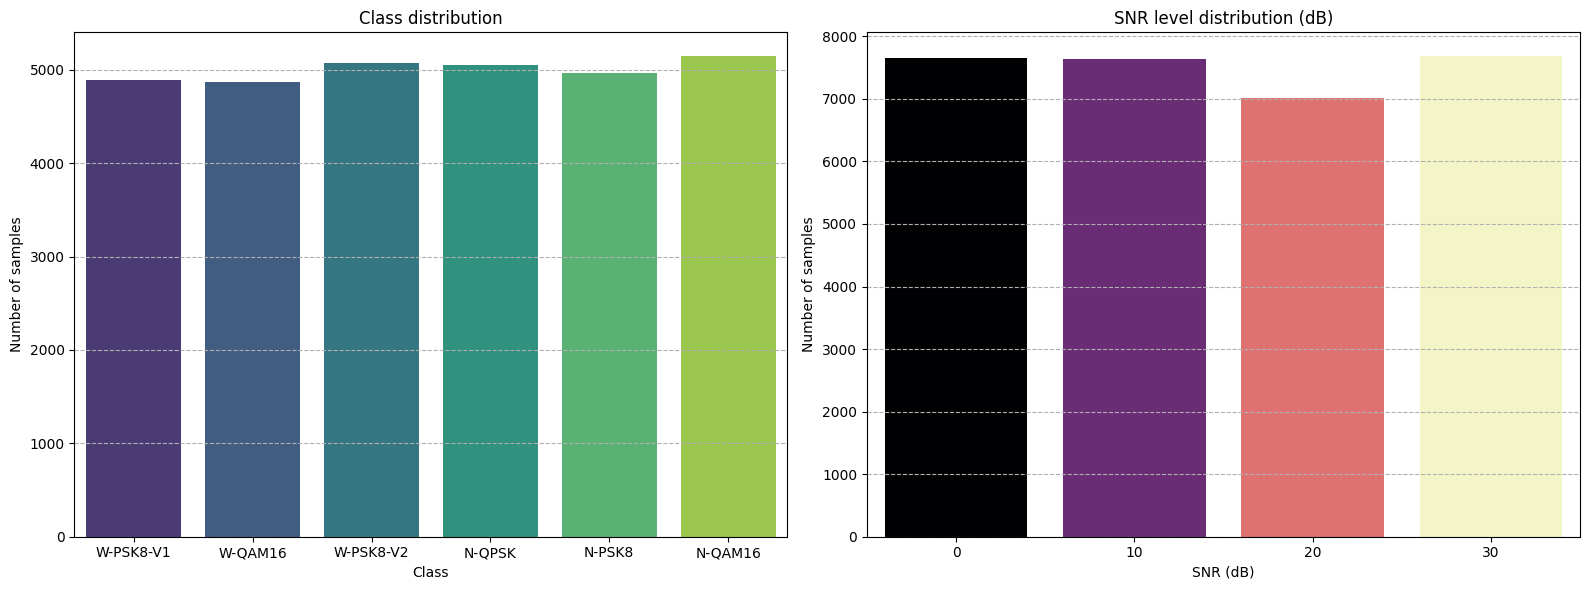

In [8]:
plt.figure(figsize=(16, 6))
label_names = [id_to_label[i] for i in labels_id]

plt.subplot(1, 2, 1)
sns.countplot(x=label_names, hue=label_names, legend=False, palette="viridis")
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.grid(axis='y', linestyle='--')

plt.subplot(1, 2, 2)
sns.countplot(x=snr, hue=snr, legend=False, palette="magma")
plt.title("SNR level distribution (dB)")
plt.xlabel("SNR (dB)")
plt.ylabel("Number of samples")
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

TODO interprétation (balance des labels)

TODO: parler des 3 features qui utilisées en entrée pour les modèles
- time domain
- Constellation
- Spectrogramme

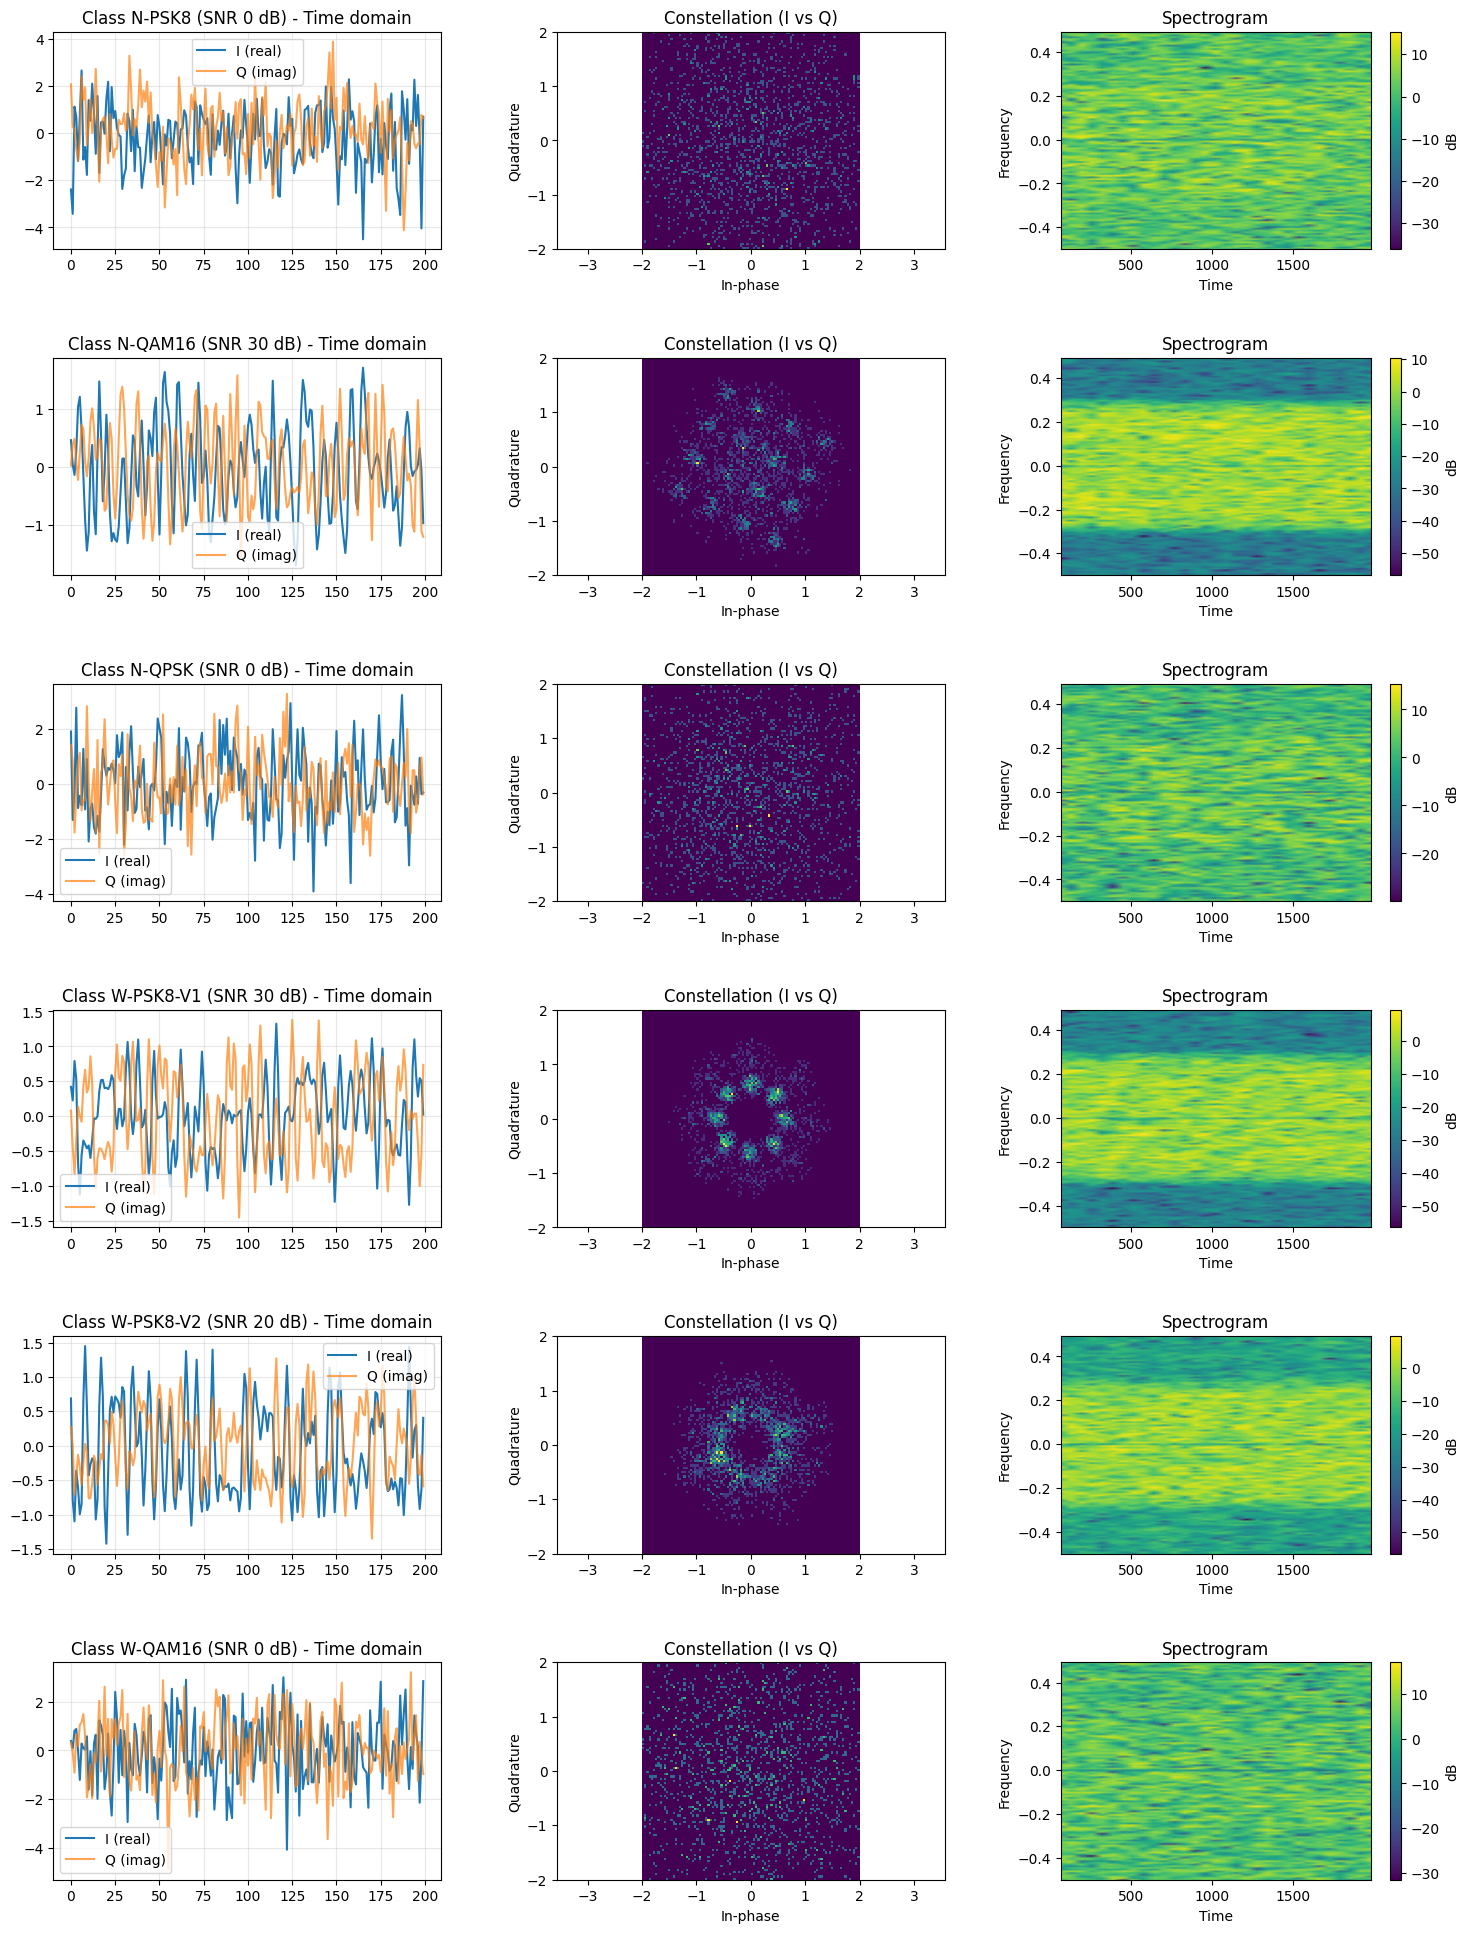

In [9]:
unique_labels = np.array(list(labels.keys()))
_, axes = plt.subplots(6, 3, figsize=(18, 4 * 6))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, label_id in enumerate(unique_labels):
    indices = np.where(labels_id == label_id)[0]
    idx = np.random.choice(indices)

    sig_sample = signals[idx] # (2048, 2)
    label_name_sample = id_to_label[label_id]
    snr_sample = snr[idx]

    t_200 = np.arange(200)
    axes[i, 0].plot(t_200, sig_sample[:200, 0], label='I (real)')
    axes[i, 0].plot(t_200, sig_sample[:200, 1], label='Q (imag)', alpha=0.7)
    axes[i, 0].set_title(f"Class {label_name_sample} (SNR {snr_sample} dB) - Time domain")
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)

    axes[i, 1].hist2d(sig_sample[:, 0], sig_sample[:, 1], bins=100, range=[[-2, 2], [-2, 2]])
    axes[i, 1].set_title("Constellation (I vs Q)")
    axes[i, 1].set_xlabel("In-phase")
    axes[i, 1].set_ylabel("Quadrature")
    axes[i, 1].axis('equal')

    sig_complex = sig_sample[:, 0] + 1j * sig_sample[:, 1]
    f, t, Sxx = spectrogram(sig_complex, fs=1.0, nperseg=128, noverlap=64, return_onesided=False)
    Sxx = np.fft.fftshift(Sxx, axes=0)
    f = np.fft.fftshift(f)

    im = axes[i, 2].pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
    axes[i, 2].set_title("Spectrogram")
    axes[i, 2].set_ylabel("Frequency")
    axes[i, 2].set_xlabel("Time")
    plt.colorbar(im, ax=axes[i, 2], label='dB')

plt.show()

TODO interpretation

## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch. 
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets : 
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones 
    
Un dataset prend la forme 
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici 

In [10]:
class RadioDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        super().__init__()

        with h5py.File(path_to_data , 'r') as data:
            self.signals = np.array(data['signaux'])
            self.snr =  np.array(data['snr'])
            self.labels_id = np.array(data['labels'])
            self.labels_lookup_table = get_labels(data)

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, i):
        signal = torch.tensor(self.signals[i], dtype = torch.float32)
        signal = signal.permute(1, 0)       # Make it compatible with conv1d
        snr = torch.tensor(self.snr[i], dtype = torch.float32)
        label_id = torch.tensor(self.labels_id[i], dtype=torch.long)
        return [signal, snr, label_id]

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [11]:
train_dataset = RadioDataset(TRAIN_PATH)
train_dataset[0]

[tensor([[-1.6314, -1.8611, -1.3227,  ...,  2.5525, -2.1447,  1.5685],
         [ 0.1021,  1.0588, -0.3088,  ..., -1.1177, -0.1418,  1.4364]]),
 tensor(0.),
 tensor(4)]

In [12]:
val_dataset = RadioDataset(VAL_PATH)
val_dataset[0]

[tensor([[-0.4053,  0.5106,  0.7306,  ...,  1.2352,  0.7845, -0.5375],
         [-0.3713, -0.4544, -0.6985,  ...,  0.3386, -0.0637, -0.5484]]),
 tensor(30.),
 tensor(4)]

In [13]:
test_dataset = RadioDataset(TEST_PATH)
test_dataset[0]

[tensor([[ 0.4394, -0.0987, -0.1903,  ..., -0.7404, -0.5464,  0.3961],
         [ 0.6084, -0.6441, -1.3845,  ...,  0.9245,  0.4290, -0.4255]]),
 tensor(30.),
 tensor(4)]

Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset. 
La cellule suivante donne un exemple d'utilisation

In [14]:
BATCH_SIZE = 128
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
dataloader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Testez le dataloader pour différentes valeurs de batch_size 

In [15]:
x, s, y = next(iter(dataloader_train))
print(f"Batch shapes -> Signal: {x.shape}, SNR: {s.shape}, Label: {y.shape}")

Batch shapes -> Signal: torch.Size([128, 2, 2048]), SNR: torch.Size([128]), Label: torch.Size([128])


## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier). 

Ce modèle doit comporter moins de 10000 paramètres libres. 

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [16]:
class DumbModel(nn.Module):
    def __init__(self, num_classes: int = 6):
        super().__init__()

        # input: (B, 2, 2048)
        self.conv1 = nn.Conv1d(
            in_channels=2, out_channels=8,
            kernel_size=7, stride=2, padding=3
        ) # (B, 8, 1024)
        self.relu = nn.ReLU() # (B, 8, 1024)
        self.pool = nn.MaxPool1d(4) # (B, 8, 256)
        self.flatten = nn.Flatten() # (B, 2048)
        self.fc = nn.Linear(8 * 256, num_classes) # (B, 6)

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

Instanciez votre modèle et testez la consistence des dimensions de ses entrées et de ses sorties vis à vis des données étudiées. Il s'agit d'un test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point.

In [17]:
dumb_model = DumbModel()
dumb_model

DumbModel(
  (conv1): Conv1d(2, 8, kernel_size=(7,), stride=(2,), padding=(3,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=2048, out_features=6, bias=True)
)

In [18]:
with torch.no_grad():
    print(f"{BATCH_SIZE = }")
    print(f"Input shape: {x.shape}")
    out = dumb_model(x)
    print(f"Output shape: {out.shape}")

BATCH_SIZE = 128
Input shape: torch.Size([128, 2, 2048])
Output shape: torch.Size([128, 6])


Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante : 

In [19]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

count_n_param(dumb_model)

12414

## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à 
- charger les données 
- les batcher 
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires 

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU 

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement 

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard. 

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs. 

In [20]:
def train_loop(model, train_loader, val_loader, epochs, device, lr=1e-3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        # train
        model.train()
        train_losses = []
        all_labels = []
        all_preds = []

        for signals, _, labels in tqdm(train_loader, desc=f"[train] epoch {epoch+1}/{epochs}"):
            signals, labels = signals.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(signals)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        avg_train_loss = np.mean(train_losses)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)

        # validation
        model.eval()
        val_losses = []
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for signals, _, labels in tqdm(val_loader, desc=f"[validation] epoch {epoch+1}/{epochs}"):
                signals, labels = signals.to(device), labels.to(device)

                outputs = model(signals)
                loss = criterion(outputs, labels)

                val_losses.append(loss.item())

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = np.mean(val_losses)
        val_acc = accuracy_score(all_labels, all_preds)

        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        print(f"[Epoch: {epoch+1}/{epochs}] loss_train: {avg_train_loss:.4f} | accuracy_train: {train_acc:.4f} | loss_val: {avg_val_loss:.4f} | accuracy_val: {val_acc:.4f}\n")

    return history

In [21]:
device = 'cuda' if  torch.cuda.is_available() else 'cpu'
save_model_path = 'baseline.pth'

dumb_model = DumbModel()

history_dumb = train_loop(
    model=dumb_model, train_loader=dataloader_train,
    val_loader=dataloader_val, epochs=30,
    lr=0.002, device=device
)

torch.save(dumb_model.state_dict(), save_model_path)

[validation] epoch 1/30: 100%|██████████| 79/79 [00:00<00:00, 302.04it/s]


[Epoch: 1/30] loss_train: 1.4563 | accuracy_train: 0.3031 | loss_val: 1.2161 | accuracy_val: 0.3318



[validation] epoch 2/30: 100%|██████████| 79/79 [00:00<00:00, 310.10it/s]


[Epoch: 2/30] loss_train: 1.1651 | accuracy_train: 0.3744 | loss_val: 1.1837 | accuracy_val: 0.3320



[validation] epoch 3/30: 100%|██████████| 79/79 [00:00<00:00, 286.54it/s]


[Epoch: 3/30] loss_train: 1.1172 | accuracy_train: 0.4153 | loss_val: 1.1879 | accuracy_val: 0.3362



[validation] epoch 4/30: 100%|██████████| 79/79 [00:00<00:00, 292.57it/s]


[Epoch: 4/30] loss_train: 1.0935 | accuracy_train: 0.4371 | loss_val: 1.1904 | accuracy_val: 0.3502



[validation] epoch 5/30: 100%|██████████| 79/79 [00:00<00:00, 197.24it/s]


[Epoch: 5/30] loss_train: 1.0609 | accuracy_train: 0.4620 | loss_val: 1.1779 | accuracy_val: 0.3707



[validation] epoch 6/30: 100%|██████████| 79/79 [00:00<00:00, 233.49it/s]


[Epoch: 6/30] loss_train: 1.0307 | accuracy_train: 0.4938 | loss_val: 1.1892 | accuracy_val: 0.3849



[validation] epoch 7/30: 100%|██████████| 79/79 [00:00<00:00, 266.56it/s]


[Epoch: 7/30] loss_train: 1.0035 | accuracy_train: 0.5211 | loss_val: 1.1502 | accuracy_val: 0.4375



[validation] epoch 8/30: 100%|██████████| 79/79 [00:00<00:00, 276.46it/s]


[Epoch: 8/30] loss_train: 0.9578 | accuracy_train: 0.5578 | loss_val: 1.1355 | accuracy_val: 0.4600



[validation] epoch 9/30: 100%|██████████| 79/79 [00:00<00:00, 279.44it/s]


[Epoch: 9/30] loss_train: 0.9118 | accuracy_train: 0.5862 | loss_val: 1.0939 | accuracy_val: 0.4907



[validation] epoch 10/30: 100%|██████████| 79/79 [00:00<00:00, 258.79it/s]


[Epoch: 10/30] loss_train: 0.8733 | accuracy_train: 0.6141 | loss_val: 1.0825 | accuracy_val: 0.5085



[validation] epoch 11/30: 100%|██████████| 79/79 [00:00<00:00, 238.72it/s]


[Epoch: 11/30] loss_train: 0.8465 | accuracy_train: 0.6240 | loss_val: 1.0721 | accuracy_val: 0.5176



[validation] epoch 12/30: 100%|██████████| 79/79 [00:00<00:00, 253.80it/s]


[Epoch: 12/30] loss_train: 0.8220 | accuracy_train: 0.6349 | loss_val: 1.0499 | accuracy_val: 0.5286



[validation] epoch 13/30: 100%|██████████| 79/79 [00:00<00:00, 289.43it/s]


[Epoch: 13/30] loss_train: 0.8098 | accuracy_train: 0.6377 | loss_val: 1.0436 | accuracy_val: 0.5292



[validation] epoch 14/30: 100%|██████████| 79/79 [00:00<00:00, 275.45it/s]


[Epoch: 14/30] loss_train: 0.7962 | accuracy_train: 0.6447 | loss_val: 1.0553 | accuracy_val: 0.5346



[validation] epoch 15/30: 100%|██████████| 79/79 [00:00<00:00, 284.71it/s]


[Epoch: 15/30] loss_train: 0.7813 | accuracy_train: 0.6517 | loss_val: 1.0676 | accuracy_val: 0.5364



[validation] epoch 16/30: 100%|██████████| 79/79 [00:00<00:00, 302.91it/s]


[Epoch: 16/30] loss_train: 0.7689 | accuracy_train: 0.6554 | loss_val: 1.1017 | accuracy_val: 0.5318



[validation] epoch 17/30: 100%|██████████| 79/79 [00:00<00:00, 301.31it/s]


[Epoch: 17/30] loss_train: 0.7730 | accuracy_train: 0.6543 | loss_val: 1.1217 | accuracy_val: 0.5252



[validation] epoch 18/30: 100%|██████████| 79/79 [00:00<00:00, 286.40it/s]


[Epoch: 18/30] loss_train: 0.7685 | accuracy_train: 0.6539 | loss_val: 1.1206 | accuracy_val: 0.5382



[validation] epoch 19/30: 100%|██████████| 79/79 [00:00<00:00, 267.00it/s]


[Epoch: 19/30] loss_train: 0.7557 | accuracy_train: 0.6582 | loss_val: 1.0706 | accuracy_val: 0.5439



[validation] epoch 20/30: 100%|██████████| 79/79 [00:00<00:00, 292.88it/s]


[Epoch: 20/30] loss_train: 0.7431 | accuracy_train: 0.6652 | loss_val: 1.0909 | accuracy_val: 0.5412



[validation] epoch 21/30: 100%|██████████| 79/79 [00:00<00:00, 292.39it/s]


[Epoch: 21/30] loss_train: 0.7505 | accuracy_train: 0.6586 | loss_val: 1.1045 | accuracy_val: 0.5452



[validation] epoch 22/30: 100%|██████████| 79/79 [00:00<00:00, 288.51it/s]


[Epoch: 22/30] loss_train: 0.7319 | accuracy_train: 0.6702 | loss_val: 1.0735 | accuracy_val: 0.5435



[validation] epoch 23/30: 100%|██████████| 79/79 [00:00<00:00, 293.59it/s]


[Epoch: 23/30] loss_train: 0.7304 | accuracy_train: 0.6715 | loss_val: 1.1163 | accuracy_val: 0.5378



[validation] epoch 24/30: 100%|██████████| 79/79 [00:00<00:00, 292.37it/s]


[Epoch: 24/30] loss_train: 0.7319 | accuracy_train: 0.6663 | loss_val: 1.1174 | accuracy_val: 0.5469



[validation] epoch 25/30: 100%|██████████| 79/79 [00:00<00:00, 305.60it/s]


[Epoch: 25/30] loss_train: 0.7241 | accuracy_train: 0.6715 | loss_val: 1.0869 | accuracy_val: 0.5489



[validation] epoch 26/30: 100%|██████████| 79/79 [00:00<00:00, 301.86it/s]


[Epoch: 26/30] loss_train: 0.7210 | accuracy_train: 0.6718 | loss_val: 1.1250 | accuracy_val: 0.5317



[validation] epoch 27/30: 100%|██████████| 79/79 [00:00<00:00, 305.56it/s]


[Epoch: 27/30] loss_train: 0.7161 | accuracy_train: 0.6728 | loss_val: 1.1399 | accuracy_val: 0.5350



[validation] epoch 28/30: 100%|██████████| 79/79 [00:00<00:00, 302.13it/s]


[Epoch: 28/30] loss_train: 0.7151 | accuracy_train: 0.6743 | loss_val: 1.1249 | accuracy_val: 0.5464



[validation] epoch 29/30: 100%|██████████| 79/79 [00:00<00:00, 299.27it/s]


[Epoch: 29/30] loss_train: 0.7207 | accuracy_train: 0.6701 | loss_val: 1.1822 | accuracy_val: 0.5505



[validation] epoch 30/30: 100%|██████████| 79/79 [00:00<00:00, 304.19it/s]

[Epoch: 30/30] loss_train: 0.7147 | accuracy_train: 0.6725 | loss_val: 1.2565 | accuracy_val: 0.5236



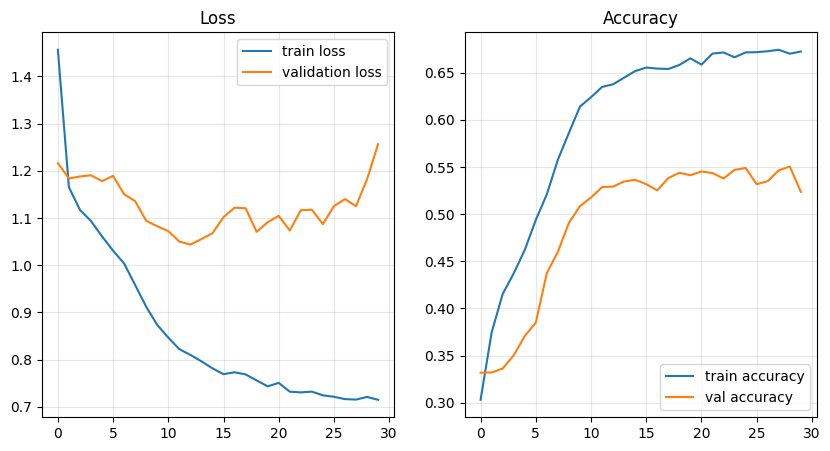

In [22]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dumb['train_loss'], label='train loss')
plt.plot(history_dumb['val_loss'], label='validation loss')
plt.title('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_dumb['train_acc'], label='train accuracy')
plt.plot(history_dumb['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

TODO: interpréter les résultats (overfitting + modèle peu performant)

In [23]:
def plot_confusion_matrix(model, dataloader, device, label_to_id):
    model.eval()
    model.to(device)
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 5: # useful later in the notebook
                x, _, _, y, _ = [item.to(device) for item in batch]
            else:
                x, y = batch[0].to(device), batch[-1].to(device)

            logits = model(x)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    class_names = [id_to_label[i] for i in range(len(label_to_id))]

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

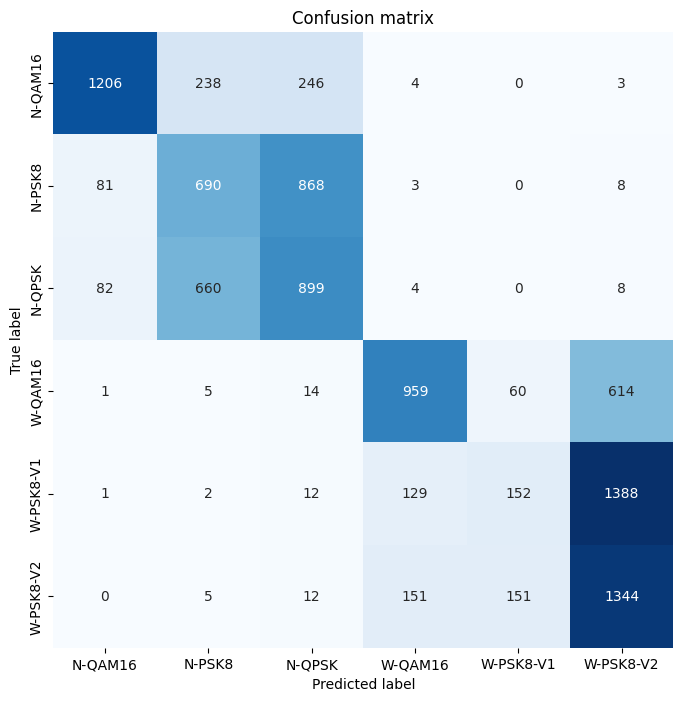

In [24]:
plot_confusion_matrix(dumb_model, dataloader_test, device, label_to_id)

Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction 
```python
modele = torch.load(...) 
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [25]:
dumb_model_loaded = DumbModel()
state_dict = torch.load(save_model_path, weights_only=True)
dumb_model_loaded.load_state_dict(state_dict)

x, _, _ = next(iter(dataloader_train))
outputs = dumb_model_loaded(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {outputs.shape}")
print(f"Diversity of predicted labels: {torch.unique(torch.argmax(outputs, dim=1))}")

Input shape: torch.Size([128, 2, 2048])
Output shape: torch.Size([128, 6])
Diversity of predicted labels: tensor([0, 1, 2, 3, 4, 5])


## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou si vous avancez suffisamment vite plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement. 
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps, si vous le souhaitez vous pouvez tenter de mettre en place des stratégies autour de l'utilisation des données d'entraînement pour améliorer vos résultats. Si vous cherchez à mettre en place de l'augmentation de données vous pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch. 

TODO: expliquer l'archi du nouveau réseau
-> + utilisation du 'nn.Sequential' car plus facile pour l'inférence (method forward)

In [26]:
class BetterDumbModel(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        self.features = nn.Sequential(
            # block 1
            nn.Conv1d(2, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # block 2
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # block 3
            nn.Conv1d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # block 4
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [27]:
better_dumb_model = BetterDumbModel()
print(f"Paramètres BetterDumbModel: {count_n_param(better_dumb_model)}")

Paramètres BetterDumbModel: 734662


In [28]:
history_bdm = train_loop(better_dumb_model, dataloader_train, dataloader_val, epochs=30, device=device, lr=0.002)

torch.save(better_dumb_model.state_dict(), 'better_dumb_model.pth')

[validation] epoch 1/30: 100%|██████████| 79/79 [00:01<00:00, 74.12it/s]


[Epoch: 1/30] loss_train: 0.8258 | accuracy_train: 0.5271 | loss_val: 0.7689 | accuracy_val: 0.5671



[validation] epoch 2/30: 100%|██████████| 79/79 [00:01<00:00, 77.79it/s]


[Epoch: 2/30] loss_train: 0.6161 | accuracy_train: 0.6198 | loss_val: 0.6439 | accuracy_val: 0.6568



[validation] epoch 3/30: 100%|██████████| 79/79 [00:01<00:00, 77.73it/s]


[Epoch: 3/30] loss_train: 0.5305 | accuracy_train: 0.6794 | loss_val: 0.4871 | accuracy_val: 0.7042



[validation] epoch 4/30: 100%|██████████| 79/79 [00:01<00:00, 78.21it/s]


[Epoch: 4/30] loss_train: 0.5172 | accuracy_train: 0.6934 | loss_val: 0.5351 | accuracy_val: 0.6845



[validation] epoch 5/30: 100%|██████████| 79/79 [00:01<00:00, 77.19it/s]


[Epoch: 5/30] loss_train: 0.4913 | accuracy_train: 0.6956 | loss_val: 0.4704 | accuracy_val: 0.6945



[validation] epoch 6/30: 100%|██████████| 79/79 [00:01<00:00, 74.85it/s]


[Epoch: 6/30] loss_train: 0.4746 | accuracy_train: 0.7067 | loss_val: 1.2477 | accuracy_val: 0.5421



[validation] epoch 7/30: 100%|██████████| 79/79 [00:01<00:00, 77.36it/s]


[Epoch: 7/30] loss_train: 0.4772 | accuracy_train: 0.7058 | loss_val: 2.8191 | accuracy_val: 0.5015



[validation] epoch 8/30: 100%|██████████| 79/79 [00:01<00:00, 77.05it/s]


[Epoch: 8/30] loss_train: 0.4692 | accuracy_train: 0.7142 | loss_val: 0.4550 | accuracy_val: 0.7239



[validation] epoch 9/30: 100%|██████████| 79/79 [00:01<00:00, 77.21it/s]


[Epoch: 9/30] loss_train: 0.4584 | accuracy_train: 0.7191 | loss_val: 0.5123 | accuracy_val: 0.7179



[validation] epoch 10/30: 100%|██████████| 79/79 [00:01<00:00, 77.33it/s]


[Epoch: 10/30] loss_train: 0.4568 | accuracy_train: 0.7210 | loss_val: 5.5490 | accuracy_val: 0.4875



[validation] epoch 11/30: 100%|██████████| 79/79 [00:01<00:00, 77.19it/s]


[Epoch: 11/30] loss_train: 0.4529 | accuracy_train: 0.7239 | loss_val: 0.6144 | accuracy_val: 0.7044



[validation] epoch 12/30: 100%|██████████| 79/79 [00:01<00:00, 75.92it/s]


[Epoch: 12/30] loss_train: 0.4616 | accuracy_train: 0.7219 | loss_val: 0.5429 | accuracy_val: 0.6980



[validation] epoch 13/30: 100%|██████████| 79/79 [00:01<00:00, 78.15it/s]


[Epoch: 13/30] loss_train: 0.4510 | accuracy_train: 0.7237 | loss_val: 0.5532 | accuracy_val: 0.7002



[validation] epoch 14/30: 100%|██████████| 79/79 [00:01<00:00, 78.42it/s]


[Epoch: 14/30] loss_train: 0.4436 | accuracy_train: 0.7270 | loss_val: 0.9075 | accuracy_val: 0.6584



[validation] epoch 15/30: 100%|██████████| 79/79 [00:01<00:00, 78.05it/s]


[Epoch: 15/30] loss_train: 0.4376 | accuracy_train: 0.7338 | loss_val: 0.4538 | accuracy_val: 0.7303



[validation] epoch 16/30: 100%|██████████| 79/79 [00:01<00:00, 76.93it/s]


[Epoch: 16/30] loss_train: 0.4319 | accuracy_train: 0.7381 | loss_val: 5.1502 | accuracy_val: 0.4258



[validation] epoch 17/30: 100%|██████████| 79/79 [00:01<00:00, 78.23it/s]


[Epoch: 17/30] loss_train: 0.4349 | accuracy_train: 0.7378 | loss_val: 0.8075 | accuracy_val: 0.7130



[validation] epoch 18/30: 100%|██████████| 79/79 [00:01<00:00, 77.69it/s]


[Epoch: 18/30] loss_train: 0.4351 | accuracy_train: 0.7364 | loss_val: 0.4664 | accuracy_val: 0.7188



[validation] epoch 19/30: 100%|██████████| 79/79 [00:01<00:00, 77.95it/s]


[Epoch: 19/30] loss_train: 0.4268 | accuracy_train: 0.7432 | loss_val: 1.2517 | accuracy_val: 0.6856



[validation] epoch 20/30: 100%|██████████| 79/79 [00:01<00:00, 77.15it/s]


[Epoch: 20/30] loss_train: 0.4229 | accuracy_train: 0.7444 | loss_val: 0.5303 | accuracy_val: 0.7170



[validation] epoch 21/30: 100%|██████████| 79/79 [00:01<00:00, 77.67it/s]


[Epoch: 21/30] loss_train: 0.4204 | accuracy_train: 0.7536 | loss_val: 0.5759 | accuracy_val: 0.7019



[validation] epoch 22/30: 100%|██████████| 79/79 [00:01<00:00, 77.66it/s]


[Epoch: 22/30] loss_train: 0.4074 | accuracy_train: 0.7676 | loss_val: 0.5986 | accuracy_val: 0.7377



[validation] epoch 23/30: 100%|██████████| 79/79 [00:01<00:00, 76.70it/s]


[Epoch: 23/30] loss_train: 0.3825 | accuracy_train: 0.8002 | loss_val: 0.7944 | accuracy_val: 0.7978



[validation] epoch 24/30: 100%|██████████| 79/79 [00:01<00:00, 77.29it/s]


[Epoch: 24/30] loss_train: 0.3029 | accuracy_train: 0.8431 | loss_val: 0.4421 | accuracy_val: 0.8265



[validation] epoch 25/30: 100%|██████████| 79/79 [00:01<00:00, 77.32it/s]


[Epoch: 25/30] loss_train: 0.2680 | accuracy_train: 0.8556 | loss_val: 0.6463 | accuracy_val: 0.8279



[validation] epoch 26/30: 100%|██████████| 79/79 [00:01<00:00, 77.69it/s]


[Epoch: 26/30] loss_train: 0.2547 | accuracy_train: 0.8607 | loss_val: 0.7220 | accuracy_val: 0.8139



[validation] epoch 27/30: 100%|██████████| 79/79 [00:01<00:00, 76.99it/s]


[Epoch: 27/30] loss_train: 0.2494 | accuracy_train: 0.8633 | loss_val: 0.5053 | accuracy_val: 0.8331



[validation] epoch 28/30: 100%|██████████| 79/79 [00:01<00:00, 77.38it/s]


[Epoch: 28/30] loss_train: 0.2490 | accuracy_train: 0.8653 | loss_val: 7.8983 | accuracy_val: 0.7098



[validation] epoch 29/30: 100%|██████████| 79/79 [00:01<00:00, 77.70it/s]


[Epoch: 29/30] loss_train: 0.2537 | accuracy_train: 0.8633 | loss_val: 0.2801 | accuracy_val: 0.8607



[validation] epoch 30/30: 100%|██████████| 79/79 [00:01<00:00, 77.82it/s]

[Epoch: 30/30] loss_train: 0.2368 | accuracy_train: 0.8690 | loss_val: 0.3242 | accuracy_val: 0.8542



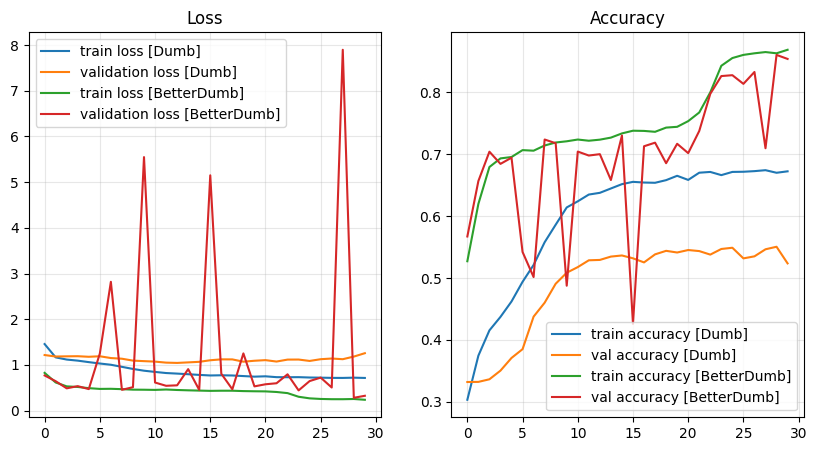

In [29]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dumb['train_loss'], label='train loss [Dumb]')
plt.plot(history_dumb['val_loss'], label='validation loss [Dumb]')
plt.plot(history_bdm['train_loss'], label='train loss [BetterDumb]')
plt.plot(history_bdm['val_loss'], label='validation loss [BetterDumb]')
plt.title('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_dumb['train_acc'], label='train accuracy [Dumb]')
plt.plot(history_dumb['val_acc'], label='val accuracy [Dumb]')
plt.plot(history_bdm['train_acc'], label='train accuracy [BetterDumb]')
plt.plot(history_bdm['val_acc'], label='val accuracy [BetterDumb]')
plt.title('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

TODO: print l'accuracy sur set de test

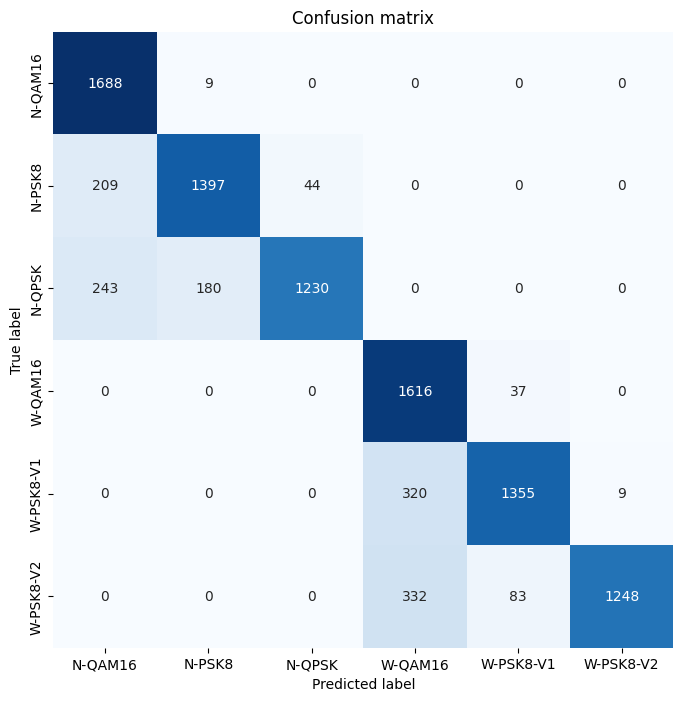

In [30]:
plot_confusion_matrix(better_dumb_model, dataloader_test, device, label_to_id)

TODO: expliquer l'utilisation de pytorch Lightning (modèle et dataloader)

In [31]:
class FeaturesDataset(Dataset):
    def __init__(self, file_path, transform=None):
        super().__init__()
        self.transform = transform

        with h5py.File(file_path, 'r') as f:
            self.signals = np.array(f['signaux'])
            self.labels = np.array(f['labels'])
            self.snr = np.array(f['snr'])
            self.label_map = {f['label_name'].attrs[k]: k for k in f['label_name'].attrs.keys()}

    def __len__(self):
        return len(self.signals)

    def get_spectrogram(self, sig_complex):
        # return_onesided=False -> to get real and imaginary numbers
        f, t, Zxx = stft(sig_complex, fs=1.0, nperseg=64, noverlap=32, return_onesided=False)
        Sxx = 10 * np.log10(np.abs(Zxx)**2 + 1e-10)

        # normalization
        Sxx = (Sxx - Sxx.mean()) / (Sxx.std() + 1e-10)

        # resize to fixed 64x64 for CNNs
        Sxx_tensor = torch.tensor(Sxx, dtype=torch.float32).unsqueeze(0).unsqueeze(0) # (1, 1, H, W)
        Sxx_resized = F.interpolate(Sxx_tensor, size=(64, 64), mode='bilinear', align_corners=False)
        return Sxx_resized.squeeze(0) # (1, 64, 64)

    def get_histogram(self, i_sig, q_sig):
        H, _, _ = np.histogram2d(i_sig, q_sig, bins=64, range=[[-2, 2], [-2, 2]], density=True)
        # normalization
        H = (H - H.mean()) / (H.std() + 1e-10)

        histogram = torch.tensor(H, dtype=torch.float32)
        return histogram.unsqueeze(0) # (1, 64, 64)

    def __getitem__(self, idx):
        # (2048, 2) trranspose to (2, 2048) for Conv1d
        raw_np = self.signals[idx]
        sig_tensor = torch.tensor(raw_np.transpose(1, 0), dtype=torch.float32)

        sig_complex = raw_np[:, 0] + 1j * raw_np[:, 1]
        spectrogram = self.get_spectrogram(sig_complex)

        histogram = self.get_histogram(raw_np[:, 0], raw_np[:, 1])

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        snr = torch.tensor(self.snr[idx], dtype=torch.float32)

        return sig_tensor, histogram, spectrogram, label, snr

In [32]:
class SignalDataModule(L.LightningDataModule):
    def __init__(self, batch_size=64, num_workers=15):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        self.train_ds = FeaturesDataset(TRAIN_PATH)
        self.val_ds = FeaturesDataset(VAL_PATH)
        self.test_ds = FeaturesDataset(TEST_PATH)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers)

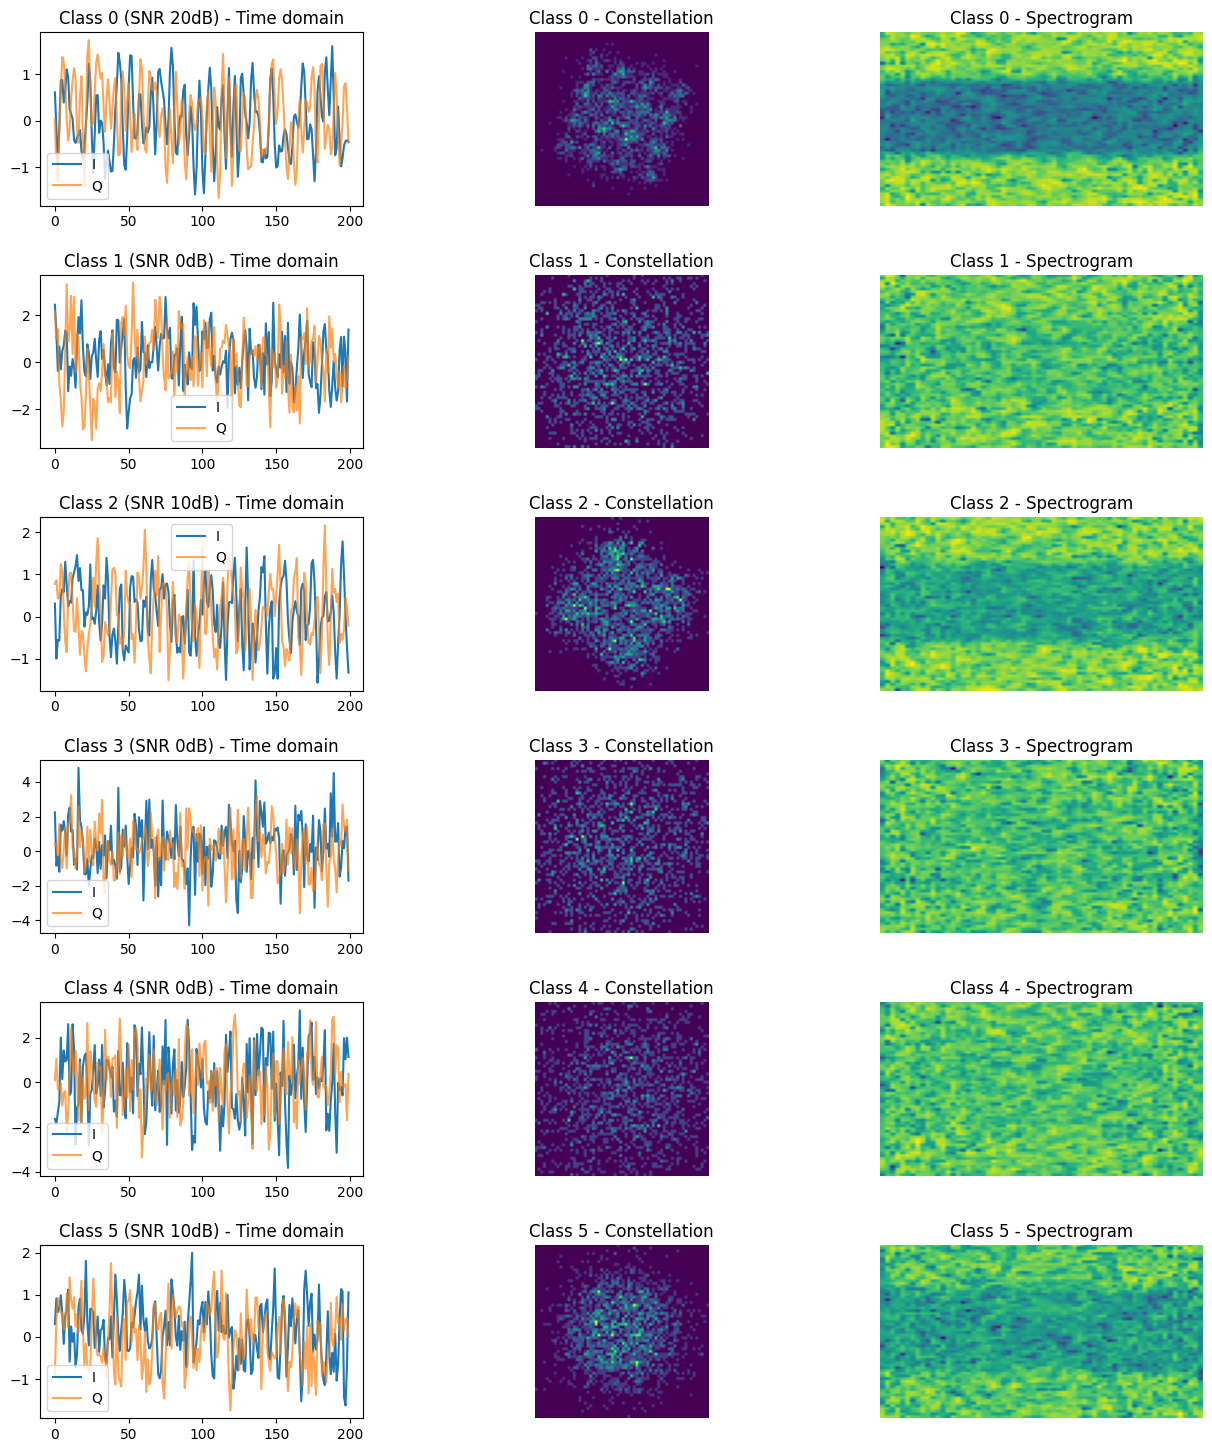

In [33]:
num_classes = 6
training_lightning_dataset = FeaturesDataset(TRAIN_PATH)

fig, axes = plt.subplots(num_classes, 3, figsize=(15, 3 * num_classes))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

found_classes = []
idx = 0

while len(found_classes) < num_classes and idx < len(training_lightning_dataset):
    sig, hist, spec, label, snr = training_lightning_dataset[idx]
    l = label.item()

    if l not in found_classes:
        found_classes.append(l)
        row = int(l)

        t = np.arange(200)
        axes[row, 0].plot(t, sig[0, :200], label='I')
        axes[row, 0].plot(t, sig[1, :200], label='Q', alpha=0.7)
        axes[row, 0].set_title(f"Class {l} (SNR {snr:.0f}dB) - Time domain")
        axes[row, 0].legend()

        axes[row, 1].imshow(hist.squeeze(), origin='lower', cmap='viridis')
        axes[row, 1].set_title(f"Class {l} - Constellation")
        axes[row, 1].axis('off')

        axes[row, 2].imshow(spec.squeeze(), origin='lower', aspect='auto', cmap='viridis')
        axes[row, 2].set_title(f"Class {l} - Spectrogram")
        axes[row, 2].axis('off')

    idx += 1

plt.show()

TODO: parler de l'architecture du modèle

TODO dire -> We only use raw signal (x) and label (y)

In [39]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.sequencial = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(out_channels)
        )

        self.relu = nn.ReLU()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.sequencial(x)
        out += self.shortcut(x)
        return self.relu(out)

class ResNet1DClassifier(L.LightningModule):
    def __init__(self, num_classes=6, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.initial_convs = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        # residual Layers
        self.layer1 = self._make_layer(32, 32, blocks=2, stride=1)
        self.layer2 = self._make_layer(32, 64, blocks=2, stride=2)
        self.layer3 = self._make_layer(64, 128, blocks=2, stride=2)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)

        self.loss_fn = nn.CrossEntropyLoss()

    def _make_layer(self, in_c, out_c, blocks, stride):
        layers = [ResidualBlock1D(in_c, out_c, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_c, out_c))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_convs(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, _, _, y, _ = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        # logs
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _, _, y, _ = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        # logs
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, _, _, y, _ = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        # logs
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            params=self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=1e-4
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.5,
            patience=3)

        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

TODO: parler des callbacks choisis...

In [40]:
datamodule = SignalDataModule(batch_size=BATCH_SIZE)
resnet_model = ResNet1DClassifier()
csv_logger = CSVLogger("logs", name="resnet_experiment")

checkpoint_cb = ModelCheckpoint(monitor='val_accuracy', mode='max', filename='resnet-best')
early_stop_cb = EarlyStopping(monitor='val_loss', patience=5)

trainer = L.Trainer(
    max_epochs=30,
    accelerator=device,
    callbacks=[checkpoint_cb, early_stop_cb],
    enable_progress_bar=True,
    logger=csv_logger
)

trainer.fit(resnet_model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | initial_convs | Sequential        | 512    | train
1 | layer1        | Sequential        | 12.5 K | train
2 | layer2        | Sequential        | 45.7 K | train
3 | layer3        | Sequential        | 181 K  | train
4 | pool          | AdaptiveAvgPool1d | 0      | train
5 | fc            | Linear            | 774    | train
6 | loss_fn       | CrossEntropyLoss  | 0      | train
------------------------------------------------------------
241 K     Trainable params
0         Non-trainable params
241 K     Total params
0.964     Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [41]:
trainer.test(model=resnet_model, dataloaders=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8546000123023987
        test_loss           0.3019413650035858
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3019413650035858, 'test_accuracy': 0.8546000123023987}]

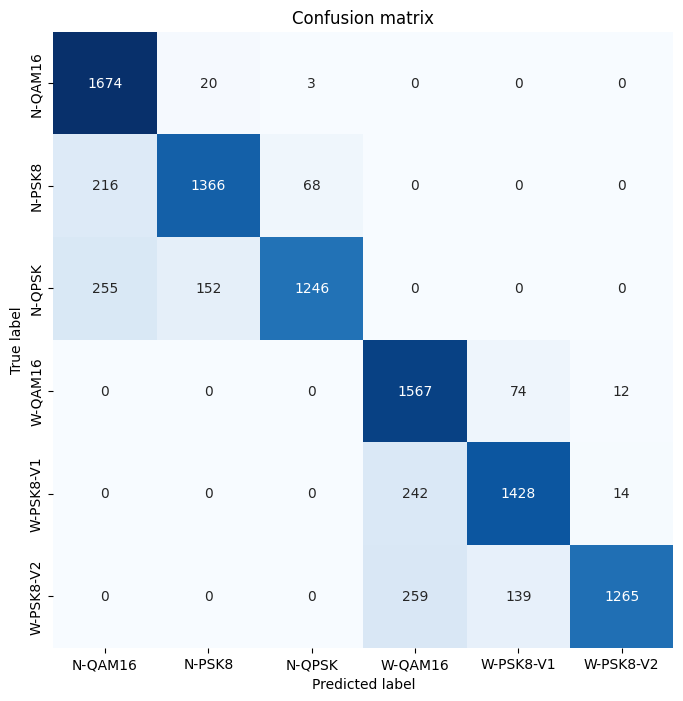

In [42]:
plot_confusion_matrix(resnet_model, datamodule.test_dataloader(), device, label_to_id)

TODO: introduire le modèle Multimodal
-> mettre un schéma de l'objectif

In [43]:
class MultiModalAE(L.LightningModule):
    def __init__(self, latent_dim=128, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # encoders:
        # signal encoder (1d)
        self.encoder_signal = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Flatten() # 2048 -> 512 length * 32 ch
        )

        # hist encoder (image 2d)
        self.encoder_histogram = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten() # 64x64 -> 16x16 * 32 ch
        )

        # spec encoder (image 2d)
        self.encoder_spectrogram = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # latent projector
        self.signal_feat_size = 32 * (2048 // 4) # 16384
        self.image_feat_size = 32 * (64 // 4) * (64 // 4) # 8192
        total_fusion_dim = self.signal_feat_size + 2 * self.image_feat_size
        self.fc_fusion = nn.Linear(total_fusion_dim, latent_dim)
        self.fc_unfuse = nn.Linear(latent_dim, total_fusion_dim)

        # decoders:
        self.decoder_signal = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 2, 5, stride=2, padding=2, output_padding=1)
        )

        self.decpder_histogram = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        )

        self.decoder_spectrogram = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def encode(self, sig, hist, spec):
        f_sig = self.encoder_signal(sig)
        f_hist = self.encoder_histogram(hist)
        f_spec = self.encoder_spectrogram(spec)
        concat = torch.cat([f_sig, f_hist, f_spec], dim=1)
        return self.fc_fusion(concat)

    def decode(self, z):
        unfused = self.fc_unfuse(z)

        idx1 = self.signal_feat_size
        idx2 = idx1 + self.image_feat_size

        feat_sig = unfused[:, :idx1].view(-1, 32, 512)
        feat_hist = unfused[:, idx1:idx2].view(-1, 32, 16, 16)
        feat_spec = unfused[:, idx2:].view(-1, 32, 16, 16)

        rec_sig = self.decoder_signal(feat_sig)
        rec_hist = self.decpder_histogram(feat_hist)
        rec_spec = self.decoder_spectrogram(feat_spec)

        return rec_sig, rec_hist, rec_spec

    def training_step(self, batch, batch_idx):
        sig, hist, spec, _, _ = batch

        z = self.encode(sig, hist, spec)
        r_sig, r_hist, r_spec = self.decode(z)

        # reconstruction loss
        l_sig = F.mse_loss(r_sig, sig)
        l_hist = F.mse_loss(r_hist, hist)
        l_spec = F.mse_loss(r_spec, spec)
        total_loss = l_sig + l_hist + l_spec

        # logs
        self.log("train_sig_loss", l_sig, prog_bar=True)
        self.log("train_hist_loss", l_hist, prog_bar=True)
        self.log("train_spec_loss", l_spec, prog_bar=True)
        self.log("train_loss", total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        sig, hist, spec, _, _ = batch
        z = self.encode(sig, hist, spec)
        r_sig, r_hist, r_spec = self.decode(z)

        l_sig = F.mse_loss(r_sig, sig)
        l_hist = F.mse_loss(r_hist, hist)
        l_spec = F.mse_loss(r_spec, spec)
        total_loss = l_sig + l_hist + l_spec

        # logs
        self.log("val_sig_loss", l_sig, prog_bar=True)
        self.log("val_hist_loss", l_hist, prog_bar=True)
        self.log("val_spec_loss", l_spec, prog_bar=True)
        self.log("val_loss", total_loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [44]:
mae_model = MultiModalAE(latent_dim=128)
ae_trainer = L.Trainer(max_epochs=20, accelerator=device)
ae_trainer.fit(mae_model, datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type       | Params | Mode 
-----------------------------------------------------------
0 | encoder_signal      | Sequential | 2.8 K  | train
1 | encoder_histogram   | Sequential | 4.8 K  | train
2 | encoder_spectrogram | Sequential | 4.8 K  | train
3 | fc_fusion           | Linear     | 4.2 M  | train
4 | fc_unfuse           | Linear     | 4.2 M  | train
5 | decoder_signal      | Sequential | 2.7 K  | train
6 | decpder_histogram   | Sequential | 4.8 K  | train
7 | decoder_spectrogram | Sequential | 4.8 K  | train
-----------------------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [45]:
def extract_embeddings(model, dataloader, device):
    model.eval()
    model.to(device)
    embeddings = []
    labels = []
    snrs = []

    with torch.no_grad():
        for batch in dataloader:
            sig, hist, spec, y, snr = [x.to(device) for x in batch]
            z = model.encode(sig, hist, spec)
            embeddings.append(z.cpu().numpy())
            labels.append(y.cpu().numpy())
            snrs.append(snr.cpu().numpy())

    return np.vstack(embeddings), np.concatenate(labels), np.concatenate(snrs)

X_train, y_train, _ = extract_embeddings(mae_model, datamodule.train_dataloader(), device)
X_test, y_test, snr_test = extract_embeddings(mae_model, datamodule.test_dataloader(), device)

In [46]:
clf = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Linear probing accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/home/alex/anaconda3/envs/altegrad/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Linear probing accuracy: 0.6699

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1697
           1       0.74      0.74      0.74      1650
           2       0.74      0.71      0.72      1653
           3       0.80      0.82      0.81      1653
           4       0.46      0.42      0.44      1684
           5       0.45      0.49      0.47      1663

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



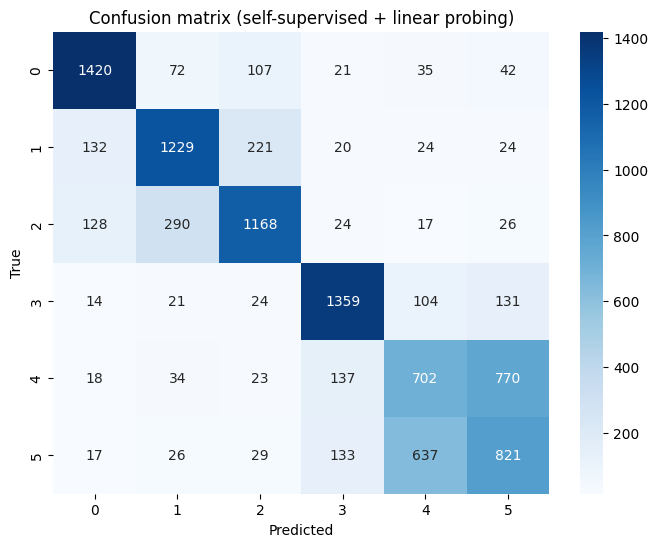

In [47]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion matrix (self-supervised + linear probing)")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

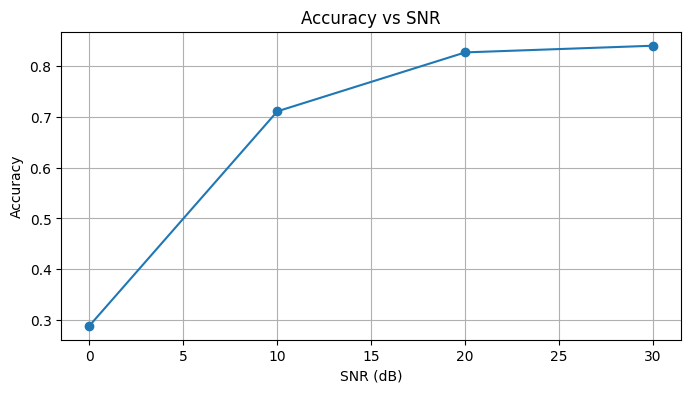

In [48]:
unique_snrs = np.unique(snr_test)
snr_acc = []
for s in unique_snrs:
    mask = (snr_test == s)
    acc_s = accuracy_score(y_test[mask], y_pred[mask])
    snr_acc.append(acc_s)

plt.figure(figsize=(8,4))
plt.plot(unique_snrs, snr_acc, marker='o')
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs SNR")
plt.grid(True)
plt.show()

TODO: parler de la  qualité de l'espace latent

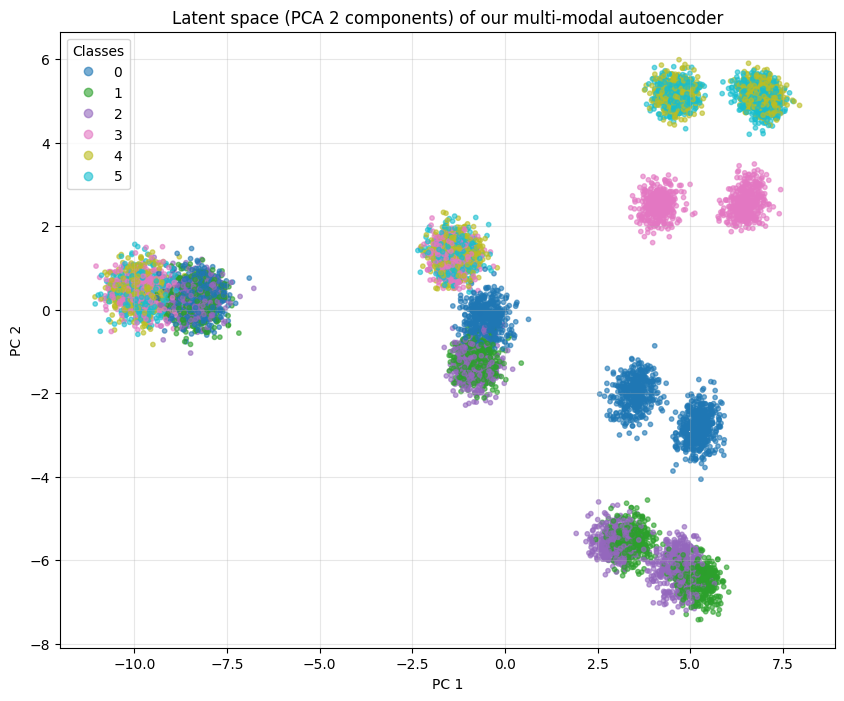

In [51]:
pca = PCA(n_components=2)
z_pca = pca.fit_transform(X_test, y_test)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test, cmap='tab10', alpha=0.6, s=10)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('Latent space (PCA 2 components) of our multi-modal autoencoder')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True, alpha=0.3)
plt.show()

## Synthèse de résultats 

Une fois que votre ou vos réseaux sont entrainés vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec. 

In [73]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### Dictionary of all Deep Learning models to compare

Note: On s'occupe de l'autoencoder séparément parce qu'il nécessite un classifieur sklearn.

In [74]:
models_dict = {
    "Dumb Model": dumb_model_loaded,
    "Better Dumb Model": better_dumb_model,
    "ResNet1D": resnet_model
}

In [75]:
results = {}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
test_loader = datamodule.test_dataloader()

In [76]:
for name, model in models_dict.items():
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []
    all_snrs = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {name}"):
            sig, _, _, y, snr = [item.to(device) for item in batch]

            logits = model(sig)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
            all_snrs.extend(snr.cpu().numpy())

    results[name] = {
        "preds": np.array(all_preds),
        "targets": np.array(all_targets),
        "snrs": np.array(all_snrs),
        "params": count_parameters(model)
}

Evaluating ResNet1D: 100%|██████████| 79/79 [00:02<00:00, 36.02it/s]


In [ ]:
mae_model.to(device)
mae_model.eval()

ae_preds = []
ae_targets = []
ae_snrs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="evaluating MultiModal AE"):
        sig, hist, spec, y, snr = [item.to(device) for item in batch]

        z = mae_model.encode(sig, hist, spec).cpu().numpy()

        batch_preds = clf.predict(z)

        ae_preds.extend(batch_preds)
        ae_targets.extend(y.cpu().numpy())
        ae_snrs.extend(snr.cpu().numpy())

        results["MultiModal AE + Linear"] = {
            "preds": np.array(ae_preds),
            "targets": np.array(ae_targets),
            "snrs": np.array(ae_snrs),
            "params": count_parameters(mae_model) + clf.coef_.size + clf.intercept_.size # param count = AE params + lr weights
        }

evaluating MultiModal AE: 100%|██████████| 79/79 [00:01<00:00, 40.63it/s]


#### Le graphique ci-dessous superpose les courbes de performance de tous les modèles.

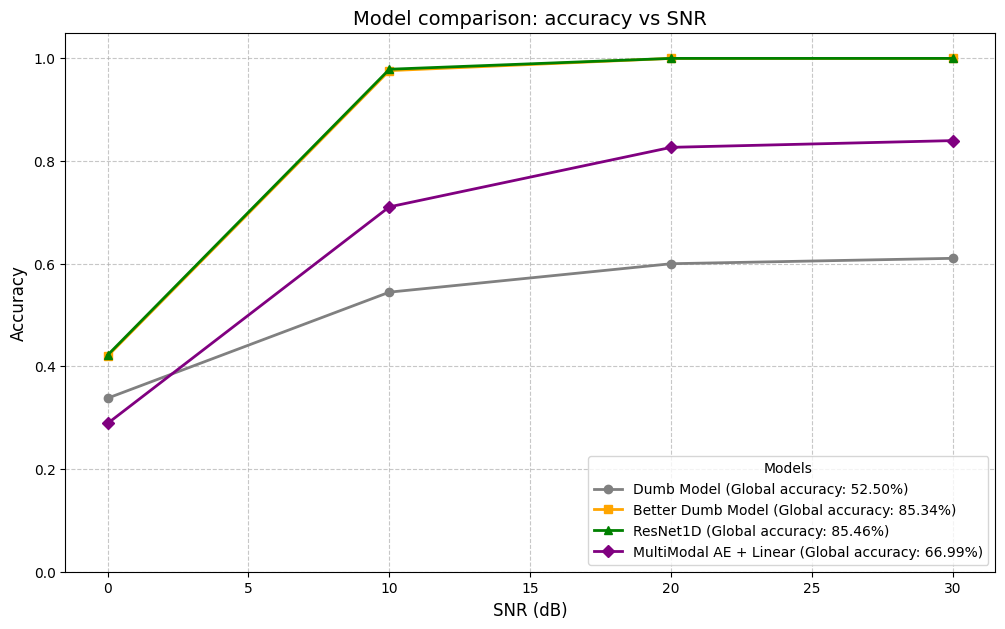

In [ ]:
plt.figure(figsize=(12, 7))

markers = ['o', 's', '^', 'D']
colors = ['gray', 'orange', 'green', 'purple']

summary_data = []

for i, (name, res) in enumerate(results.items()):
    targets = res['targets']
    preds = res['preds']
    snrs = res['snrs']

    global_acc = accuracy_score(targets, preds)

    unique_snrs = np.unique(snrs)
    acc_by_snr = []

    for s in sorted(unique_snrs):
        mask = (snrs == s)
        acc_s = accuracy_score(targets[mask], preds[mask])
        acc_by_snr.append(acc_s)

    plt.plot(sorted(unique_snrs), acc_by_snr,
            label=f"{name} (Global accuracy: {global_acc:.2%})",
            marker=markers[i % len(markers)],
            color=colors[i % len(colors)],
            linewidth=2)

    summary_data.append({
        "Model": name,
        "Parameters": f"{res['params']:,}",
        "Global accuracy": f"{global_acc:.2%}",
        "Acc @ 0dB": f"{acc_by_snr[0]:.2%}",
        "Acc @ 30dB": f"{acc_by_snr[-1]:.2%}"
    })

plt.title("Model comparison: accuracy vs SNR", fontsize=14)
plt.xlabel("SNR (dB)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(title="Models", loc='lower right')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.ylim(0, 1.05)
plt.show()

On observe que la performance s'effondre à 0dB pour tous les modèles, ce qui est attendu. À haut SNR (30dB), les modèles convergent vers leur capacité maximale.

#### Tableau Récapitulatif : Complexité vs Performance

In [68]:
df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.set_index("Model")
df_summary

,Parameters,Global Accuracy,Acc @ 0dB,Acc @ 30dB
Model,,,,
Dumb Model,"12,414",52.50%,33.80%,61.05%
Better Dumb Model,"734,662",85.34%,41.98%,100.00%
ResNet1D,"241,030",85.46%,42.19%,100.00%
MultiModal AE + Linear,"8,446,922",66.99%,28.88%,83.98%


## Conclusion

Draft

In [53]:
def evaluate_performance(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_snrs = []

    with torch.no_grad():
        for signals, snrs, labels in tqdm(loader):
            signals = signals.to(device)
            outputs = model(signals)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
            all_snrs.extend(snrs.numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_snrs)

In [54]:
preds, targets, snrs_vals = evaluate_performance(be, dataloader_test, device)

print(f"\nGlobal accuracy: {accuracy_score(targets, preds):.4f}")
print("\nClassification report:\n", classification_report(targets, preds))

100%|██████████| 79/79 [00:01<00:00, 75.84it/s]


Global accuracy: 0.8534

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.99      0.88      1697
           1       0.88      0.85      0.86      1650
           2       0.97      0.74      0.84      1653
           3       0.71      0.98      0.82      1653
           4       0.92      0.80      0.86      1684
           5       0.99      0.75      0.85      1663

    accuracy                           0.85     10000
   macro avg       0.88      0.85      0.85     10000
weighted avg       0.88      0.85      0.85     10000

